# Interrupted Time Series Analysis - Time Series with control (in R)

In [1]:
library(nlme)
library(car)
library(tseries)
library(ggplot2)
library(lmtest)
library(LSTS)
library(data.table)

Warning message:
"package 'tseries' was built under R version 3.4.4"Warning message in packageDescription("tseries", lib.loc = mylib):
"no package 'tseries' was found"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.4.4"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'LSTS' was built under R version 3.4.4"

In [83]:
data <- read.csv(file="data/gp.csv", header=TRUE, sep=",")
nrow(data) # expecting 74 weeks

[1] 74

In [99]:
data$diff <- data$rate_attend_control - data$rate_attend_pilot

## Plot data

In [90]:
head(data)

year,week,rate_attend_control,rate_attend_pilot,time,wknd,wknd_trend,end,end_trend,outlier,diff
2014,14,2.119278,4.872701,1,0,0,0,0,0,2.753423
2014,15,3.490575,4.872701,2,0,0,0,0,0,1.382125
2014,16,3.989229,6.395420,3,0,0,0,0,0,2.406191
2014,17,2.368605,4.568157,4,0,0,0,0,0,2.199552
2014,18,3.241249,7.004507,5,0,0,0,0,0,3.763259
2014,19,2.867258,6.090876,6,0,0,0,0,0,3.223617


## 1. Visual Impact Analysis of Interruptions

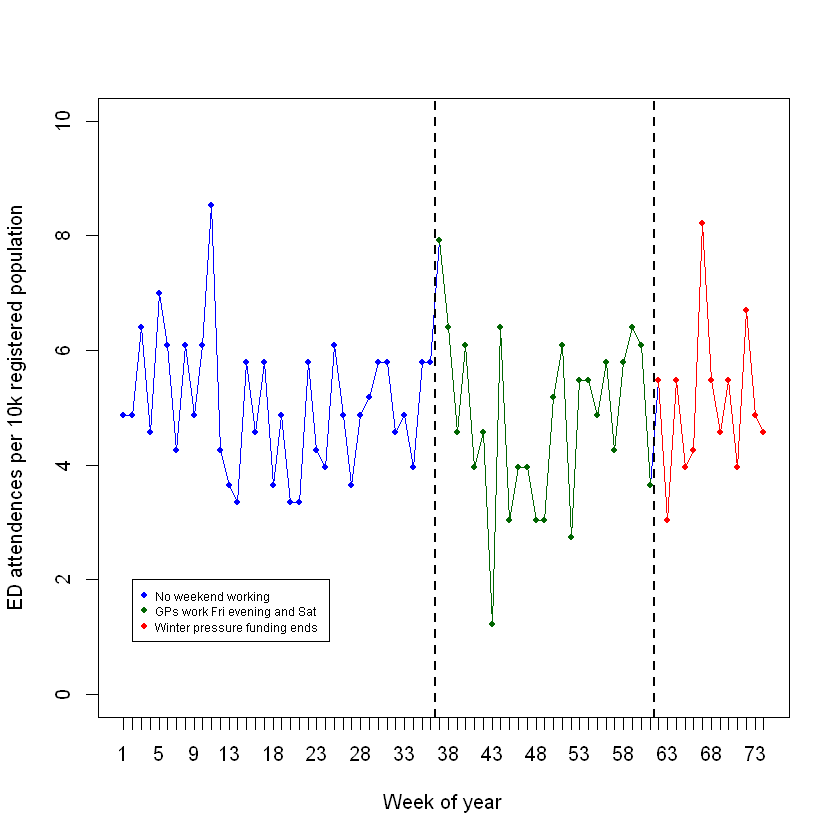

In [85]:
plot(data$time[1:74],data$rate_attend_pilot[1:74],
     ylab="ED attendences per 10k registered population",
     ylim=c(0,10),
     xlab="Week of year",
     type="l",
     col="blue",
     xaxt="n")

#Weekend working
points(data$time[37:61],data$rate_attend_pilot[37:61],
       type='l',
       col="dark green")

#Weekend working ended
points(data$time[62:74],data$rate_attend_pilot[62:74],
       type='l',
       col="red")



axis(1, at=1:74, labels=data$time[1:74])

# Add in the points for the figure
points(data$time[1:36],data$rate_attend_pilot[1:36],
       col="blue",
       pch=20)

points(data$time[37:61],data$rate_attend_pilot[37:61],
       col="dark green",
       pch=20)

points(data$time[62:74],data$rate_attend_pilot[62:74],
       col="red",
       pch=20)


# Interruption 1.  GPs begin to work Friday evenings and Saturdays
abline(v=36.5,lty=2, lwd = 2)

# Interruption 2.  GPs stop working Friday evenings and Saturdays
abline(v=61.5, lty=2, lwd = 2)

# Add in a legend
legend(x=2, y=2, legend=c("No weekend working","GPs work Fri evening and Sat", "Winter pressure funding ends"),
       col=c("blue","dark green", "red"),pch=20, cex=0.6, pt.cex = 1)


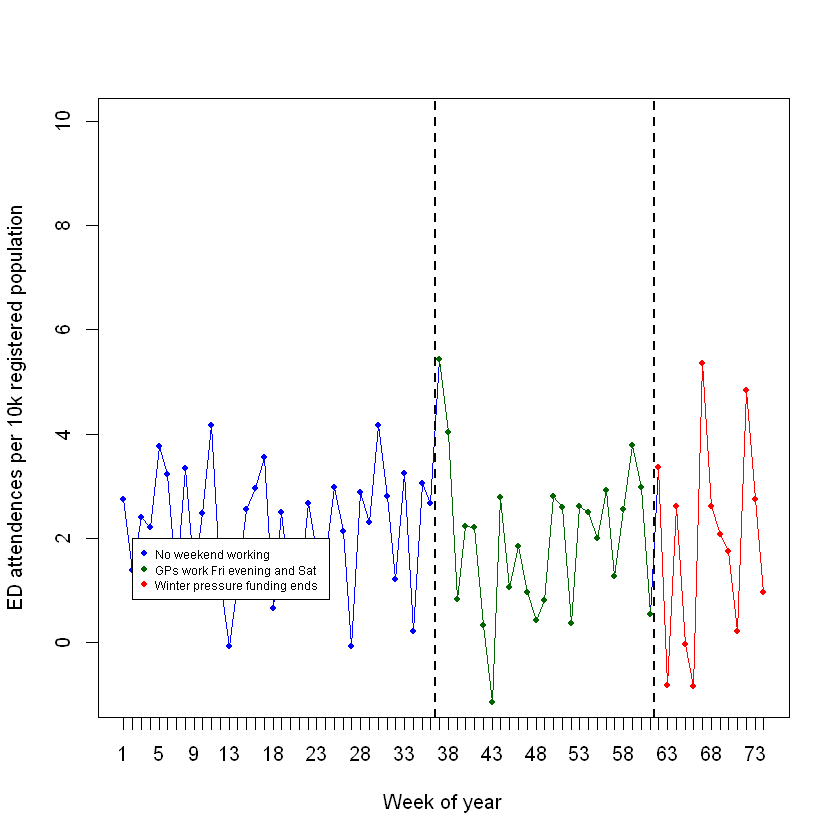

In [93]:
plot(data$time[1:74],data$diff[1:74],
     ylab="ED attendences per 10k registered population",
     ylim=c(-1,10),
     xlab="Week of year",
     type="l",
     col="blue",
     xaxt="n")

#Weekend working
points(data$time[37:61],data$diff[37:61],
       type='l',
       col="dark green")

#Weekend working ended
points(data$time[62:74],data$diff[62:74],
       type='l',
       col="red")



axis(1, at=1:74, labels=data$time[1:74])

# Add in the points for the figure
points(data$time[1:36],data$diff[1:36],
       col="blue",
       pch=20)

points(data$time[37:61],data$diff[37:61],
       col="dark green",
       pch=20)

points(data$time[62:74],data$diff[62:74],
       col="red",
       pch=20)


# Interruption 1.  GPs begin to work Friday evenings and Saturdays
abline(v=36.5,lty=2, lwd = 2)

# Interruption 2.  GPs stop working Friday evenings and Saturdays
abline(v=61.5, lty=2, lwd = 2)

# Add in a legend
legend(x=2, y=2, legend=c("No weekend working","GPs work Fri evening and Sat", "Winter pressure funding ends"),
       col=c("blue","dark green", "red"),pch=20, cex=0.6, pt.cex = 1)


## 2. ITS - Linear Regression using Generalised Least Squares

In [86]:
# A preliminary OLS regression
model_ols <- lm(rate_attend_pilot ~ time + wknd + wknd_trend + end + end_trend + outlier, data=data)
summary(model_ols)


Call:
lm(formula = rate_attend_pilot ~ time + wknd + wknd_trend + end + 
    end_trend + outlier, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1699 -0.9173  0.0137  0.8807  3.3478 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.4290689  0.4345067  12.495   <2e-16 ***
time        -0.0226915  0.0210519  -1.078   0.2850    
wknd         0.6466904  0.6668496   0.970   0.3356    
wknd_trend   0.0008824  0.0393546   0.022   0.9822    
end          0.0879002  0.8818628   0.100   0.9209    
end_trend    0.0619687  0.0989890   0.626   0.5334    
outlier     -3.8889092  1.2967745  -2.999   0.0038 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.258 on 67 degrees of freedom
Multiple R-squared:  0.1392,	Adjusted R-squared:  0.06217 
F-statistic: 1.807 on 6 and 67 DF,  p-value: 0.111


In [95]:
# A preliminary OLS regression
model_ols2 <- lm(diff ~ time + wknd + wknd_trend + end + end_trend, data=data)
summary(model_ols)


Call:
lm(formula = rate_attend_pilot ~ time + wknd + wknd_trend + end + 
    end_trend + outlier, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1699 -0.9173  0.0137  0.8807  3.3478 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.4290689  0.4345067  12.495   <2e-16 ***
time        -0.0226915  0.0210519  -1.078   0.2850    
wknd         0.6466904  0.6668496   0.970   0.3356    
wknd_trend   0.0008824  0.0393546   0.022   0.9822    
end          0.0879002  0.8818628   0.100   0.9209    
end_trend    0.0619687  0.0989890   0.626   0.5334    
outlier     -3.8889092  1.2967745  -2.999   0.0038 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.258 on 67 degrees of freedom
Multiple R-squared:  0.1392,	Adjusted R-squared:  0.06217 
F-statistic: 1.807 on 6 and 67 DF,  p-value: 0.111


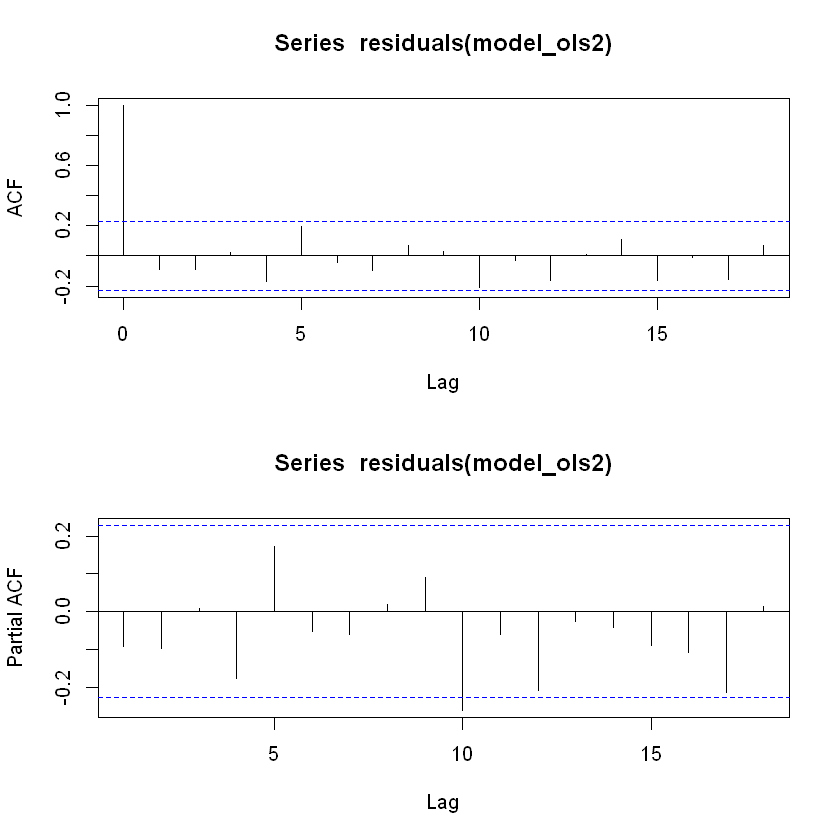

In [96]:
# Plot ACF and PACF
# Set plotting to two records on one page
par(mfrow=c(2,1))

# Produce plots
acf(residuals(model_ols2))
acf(residuals(model_ols2),type='partial')

In [87]:
# Fit the GLS regression model
gls_m1<- gls(rate_attend_pilot ~ time + wknd + wknd_trend + end + end_trend + outlier,
  data=data,
  correlation=corARMA(p=10,form=~time),
  method="ML")
summary(gls_m1)
confint(gls_m1)

Generalized least squares fit by maximum likelihood
  Model: rate_attend_pilot ~ time + wknd + wknd_trend + end + end_trend +      outlier 
  Data: data 
       AIC      BIC    logLik
  262.2706 303.7437 -113.1353

Correlation Structure: ARMA(10,0)
 Formula: ~time 
 Parameter estimate(s):
         Phi1          Phi2          Phi3          Phi4          Phi5 
-0.0525905344  0.0008707507  0.1228677898 -0.0618163089  0.0973624027 
         Phi6          Phi7          Phi8          Phi9         Phi10 
 0.0818681816  0.0706867950  0.0110349268 -0.1387962446 -0.2988329394 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept)  5.464825 0.4043778 13.514157  0.0000
time        -0.026013 0.0199780 -1.302078  0.1973
wknd         0.791760 0.6429434  1.231462  0.2225
wknd_trend   0.001843 0.0370197  0.049784  0.9604
end         -0.217580 0.8509314 -0.255696  0.7990
end_trend    0.100424 0.1038533  0.966981  0.3370
outlier     -4.061614 1.1037648 -3.679782  0.0005

 Correlati

,2.5 %,97.5 %
(Intercept),4.67225934,6.25739123
time,-0.06516916,0.01314327
wknd,-0.46838576,2.05190587
wknd_trend,-0.07071431,0.07440028
end,-1.88537444,1.45021539
end_trend,-0.10312456,0.30397306
outlier,-6.22495320,-1.89827481


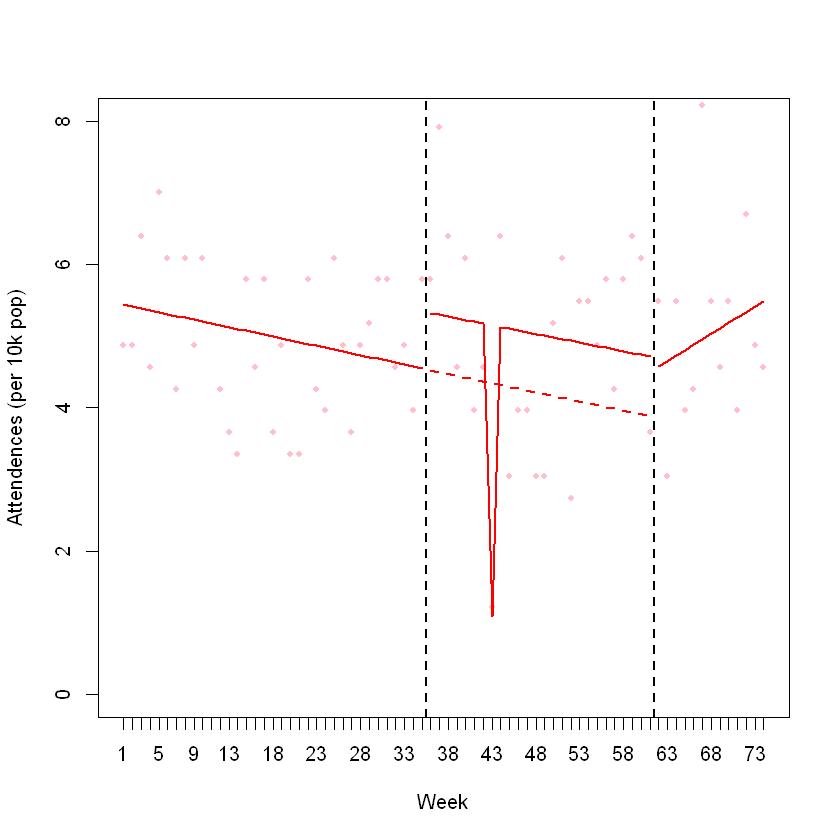

In [88]:
model_final = gls_m1
# Produce the plot, first plotting the raw data points
plot(data$time,data$rate_attend_pilot,
     ylim=c(0,8),
     ylab="Attendences (per 10k pop)",
     xlab="Week",
     pch=20,
     col="pink",
     xaxt="n")

# Add x axis with dates
#axis(1, at=1:35, labels=data$year)

# Interruption 1.  GPs begin to work Friday evenings and Saturdays
abline(v=35.5,lty=2, lwd = 2)

# Interruption 2.  GPs stop working Friday evenings and Saturdays
abline(v=61.5, lty=2, lwd = 2)

# The before line
lines(data$time[1:35], fitted(model_final)[1:35], col="red",lwd=2)

# The during line
lines(data$time[36:61], fitted(model_final)[36:61], col="red",lwd=2)

#The after line
lines(data$time[62:74], fitted(model_final)[62:74], col="red",lwd=2)

axis(1, at=1:74, labels=data$time[1:74])

#Line representing counterfactual to ED implementation
segments(36, model_final$coef[1]+model_final$coef[2]*36,
         61, model_final$coef[1]+model_final$coef[2]*61,
         lty=2, lwd=2, col='red')

# Line representing counterfactual to the ambulance implementation
#segments(41, model_final$coef[1] + model_final$coef[2]*41 +
#           model_final$coef[3] + model_final$coef[4]*15,
#         54, model_final$coef[1] + model_final$coef[2]*54 +
#           model_final$coef[3] + model_final$coef[4]*30,
#         lty=2, lwd=2, col='red')


In [100]:
# Fit the GLS regression model
gls_m2<- gls(diff ~ time + wknd + wknd_trend + end + end_trend,
  data=data,
  correlation=corARMA(p=10,form=~time),
  method="ML")
summary(gls_m2)


Generalized least squares fit by maximum likelihood
  Model: diff ~ time + wknd + wknd_trend + end + end_trend 
  Data: data 
       AIC      BIC    logLik
  278.2051 317.3742 -122.1025

Correlation Structure: ARMA(10,0)
 Formula: ~time 
 Parameter estimate(s):
       Phi1        Phi2        Phi3        Phi4        Phi5        Phi6 
-0.03945704 -0.09602922 -0.01648434 -0.19217391  0.20508870 -0.11042961 
       Phi7        Phi8        Phi9       Phi10 
-0.06270450  0.02650446  0.07557889 -0.28425415 

Coefficients:
                 Value Std.Error   t-value p-value
(Intercept) -2.2302777 0.3513880 -6.347052  0.0000
time         0.0037478 0.0174113  0.215252  0.8302
wknd         0.1062995 0.5850777  0.181684  0.8564
wknd_trend   0.0008216 0.0318427  0.025801  0.9795
end          0.5095128 0.8839529  0.576403  0.5662
end_trend   -0.0944621 0.0964745 -0.979141  0.3310

 Correlation: 
           (Intr) time   wknd   wknd_t end   
time       -0.895                            
wknd        0.

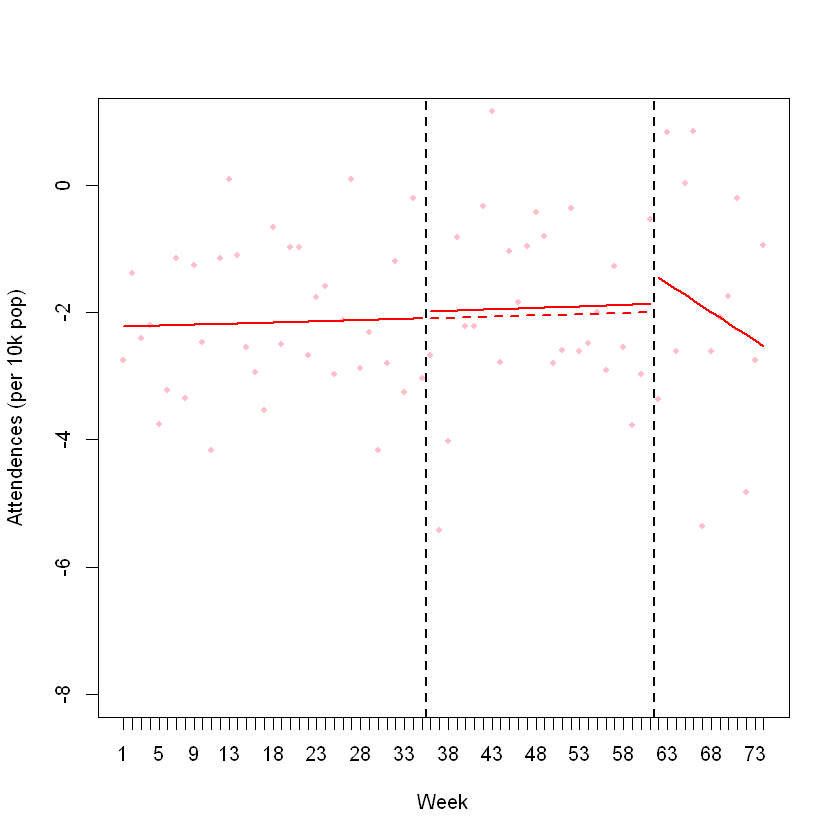

In [102]:
model_final = gls_m2
# Produce the plot, first plotting the raw data points
plot(data$time,data$diff,
     ylim=c(-8,1),
     ylab="Attendences (per 10k pop)",
     xlab="Week",
     pch=20,
     col="pink",
     xaxt="n")

# Add x axis with dates
#axis(1, at=1:35, labels=data$year)

# Interruption 1.  GPs begin to work Friday evenings and Saturdays
abline(v=35.5,lty=2, lwd = 2)

# Interruption 2.  GPs stop working Friday evenings and Saturdays
abline(v=61.5, lty=2, lwd = 2)

# The before line
lines(data$time[1:35], fitted(model_final)[1:35], col="red",lwd=2)

# The during line
lines(data$time[36:61], fitted(model_final)[36:61], col="red",lwd=2)

#The after line
lines(data$time[62:74], fitted(model_final)[62:74], col="red",lwd=2)

axis(1, at=1:74, labels=data$time[1:74])

#Line representing counterfactual to ED implementation
segments(36, model_final$coef[1]+model_final$coef[2]*36,
         61, model_final$coef[1]+model_final$coef[2]*61,
         lty=2, lwd=2, col='red')

# Line representing counterfactual to the ambulance implementation
#segments(41, model_final$coef[1] + model_final$coef[2]*41 +
#           model_final$coef[3] + model_final$coef[4]*15,
#         54, model_final$coef[1] + model_final$coef[2]*54 +
#           model_final$coef[3] + model_final$coef[4]*30,
#         lty=2, lwd=2, col='red')
